# Metabolomic Analysis of Enamel (PH Chromatography, Positive Ionization Mode)
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

## Quality Control of Raw Data

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("Rtsne")
    library("caret")
    library("MASS")
    library("ggrepel")
    library("writexl")
    library("matrixStats")
    library("devtools")
    library("ggpubr")
    
    
})

## Set session-specific options
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 120, scipen = -1)

## Define %notin% operator
`%notin%` <- Negate(`%in%`)

Warning message in fun(libname, pkgname):
“mzR has been built against a different Rcpp version (1.0.9)
than is installed on your system (1.0.14). This might lead to errors
when loading mzR. If you encounter such issues, please send a report,
including the output of sessionInfo() to the Bioc support forum at 
https://support.bioconductor.org/. For details see also
https://github.com/sneumann/mzR/wiki/mzR-Rcpp-compiler-linker-issue.”


In [2]:
## List mzXML files
mzXMLs <- list.files(path = "PH_Pos", recursive = TRUE, 
                    full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Enamel_acid", 5),rep("Enamel_pellicle_acid", 5),rep("Enamel_pellicle", 5),rep("Enamel", 5),rep("QC", 9))

analysis.order <- c(19,15,6,21,14,24,12,18,9,8,20,22,25,10,28,7,27,16,26,13, 1, 2, 3, 4, 5,11,17,23,29)
analysis.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group,
                   analysis_order = analysis.order, 
                   analysis_batch = analysis.batch, 
                   stringsAsFactors = FALSE)

In [3]:
## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(analysis.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(analysis.order),]), 
                  mode = "onDisk")

## Inspection of Internal Standards
This experiment used the following stable isotope labeled standards to normalise variability introduced by injection of the samples into the mass spectrometer:
- N-methyl-creatinine-d3, \[M+H\]: *m/z* 117.0850
- L-arginine (13C6), \[M+H\]: *m/z* 181.1391, \[M-H\]: *m/z* 179.1245
- L-phenylalanin-d2, \[M-H\]: *m/z* 168.0988, \[M-H\]: *m/z* 166.0843
- Crea, \[M+H\]: *m/z* 114.0662


Quality control at this stage includes ensuring that the internal standards have been detected properly and the within group variability is acceptable.

In [5]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(group.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")

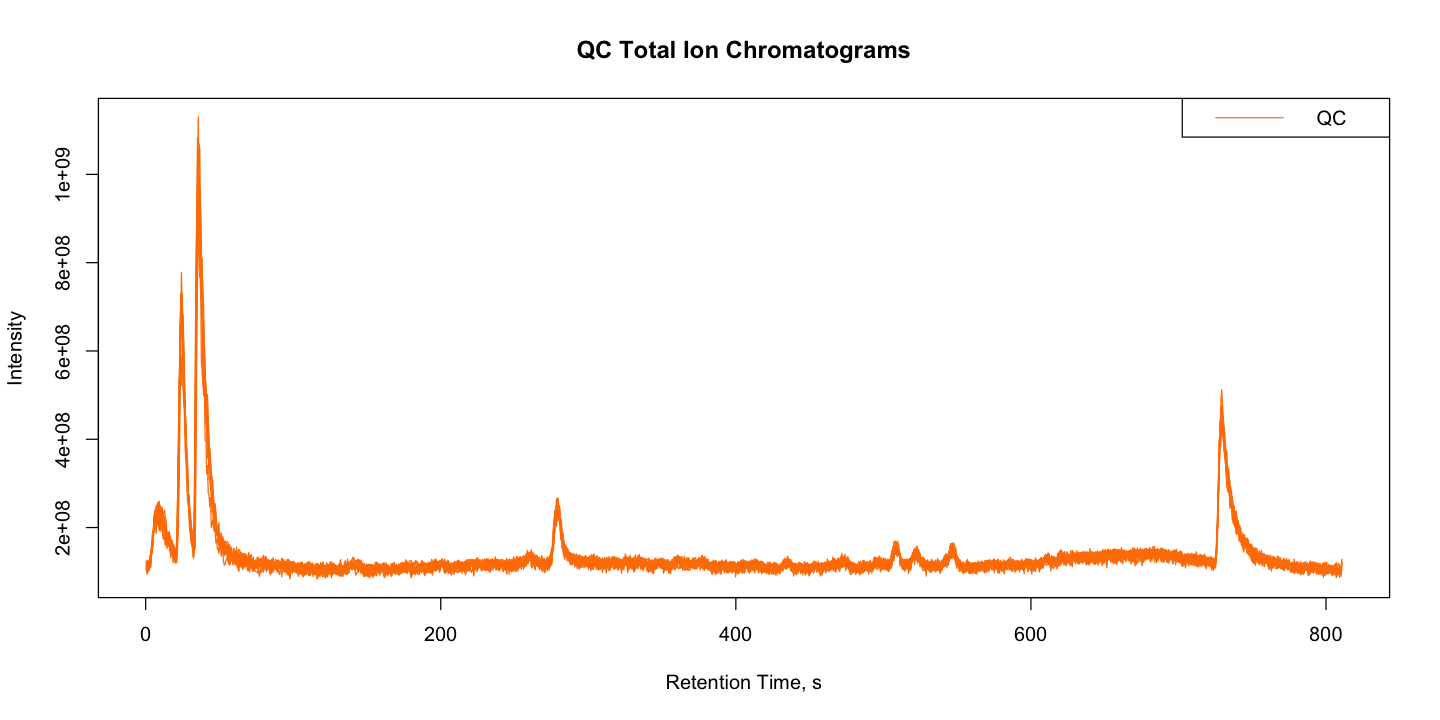

In [6]:
## Get TIC chromatograms
chroms <- chromatogram(raw)

## Plot every QC chromatogram of the data set
plot(chroms[,chroms$sample_group == "QC"], col = group.colours[chroms$sample_group],
     main = "QC Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = "QC", 
       col = group.colours[names(group.colours) == "QC"], lty = 1)

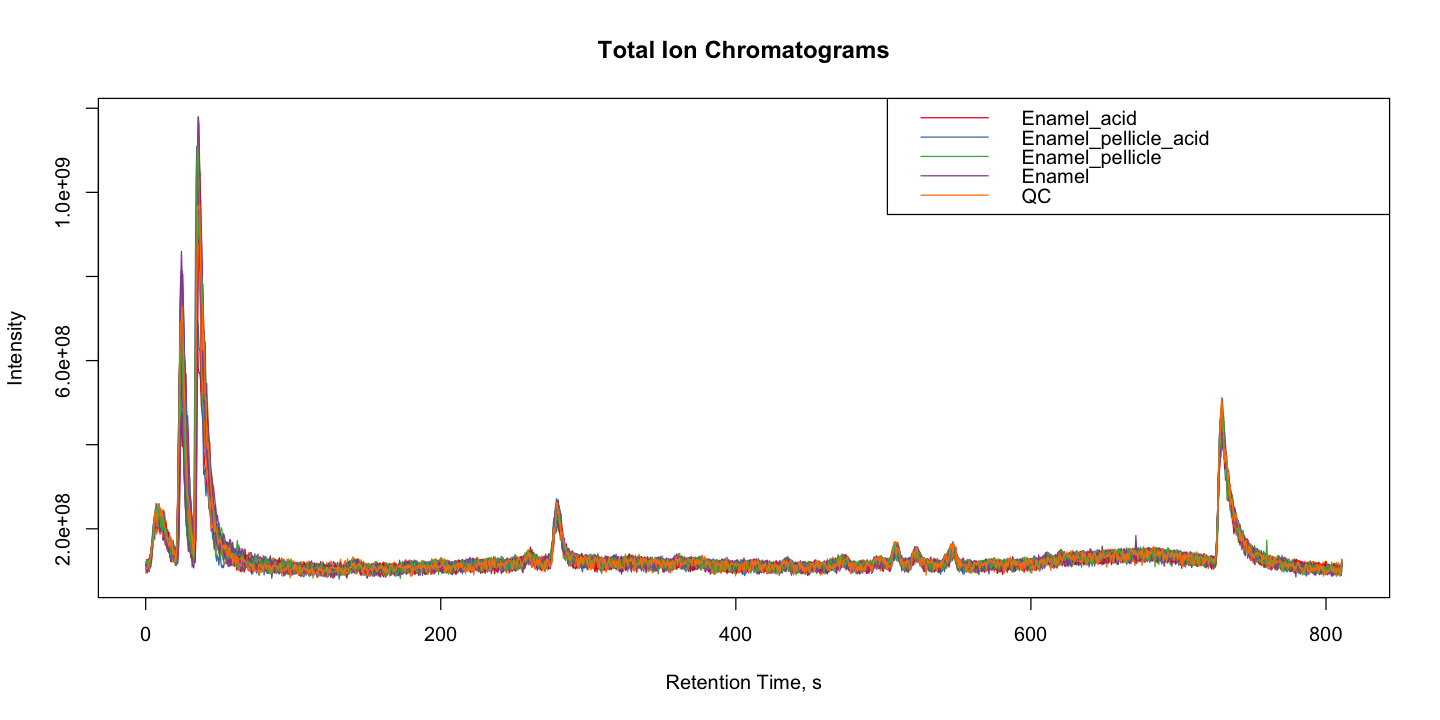

In [7]:
## Plot every chromatogram of the data set
plot(chroms, col = group.colours[chroms$sample_group],
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

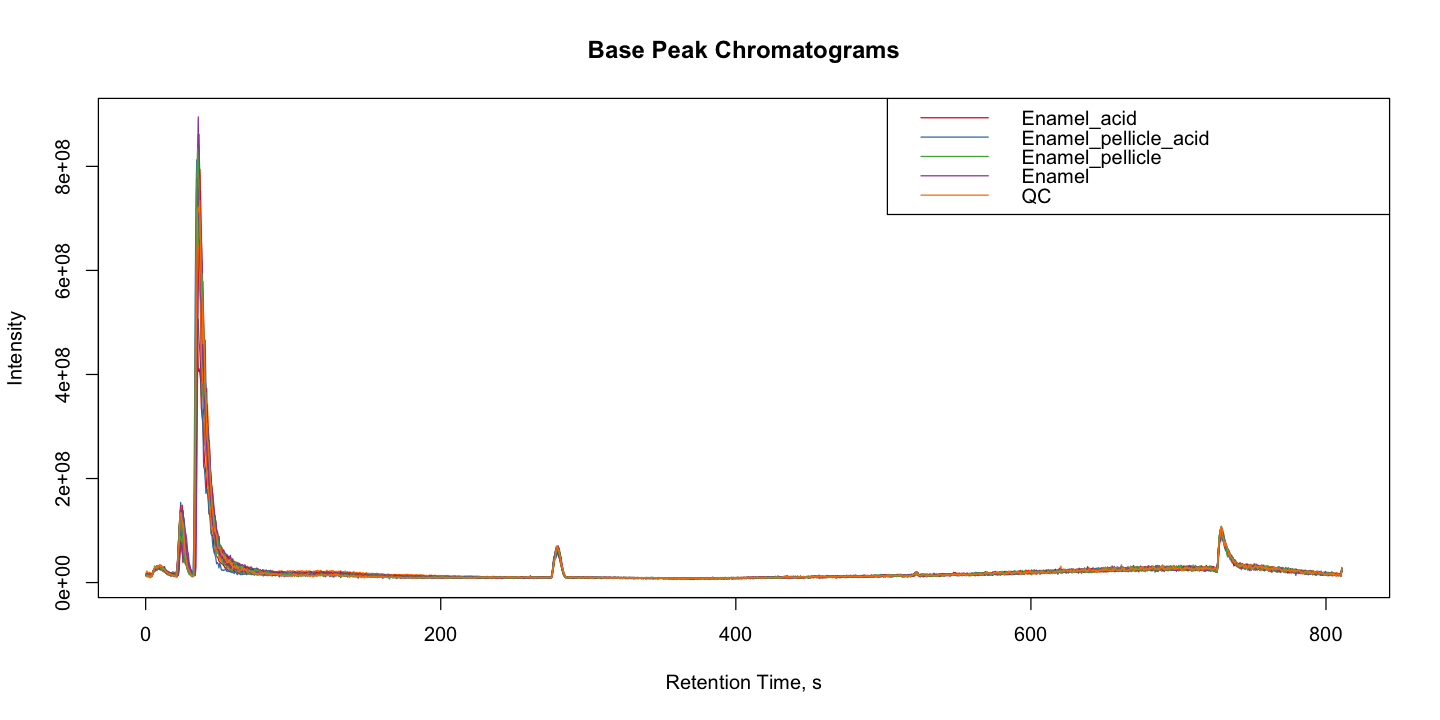

In [8]:
## Get base peak chromatograms
bps <- chromatogram(raw, aggregationFun = "max")

## Plot every base peak chromatogram of the data set
plot(bps, col = group.colours[raw$sample_group], 
     main = "Base Peak Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

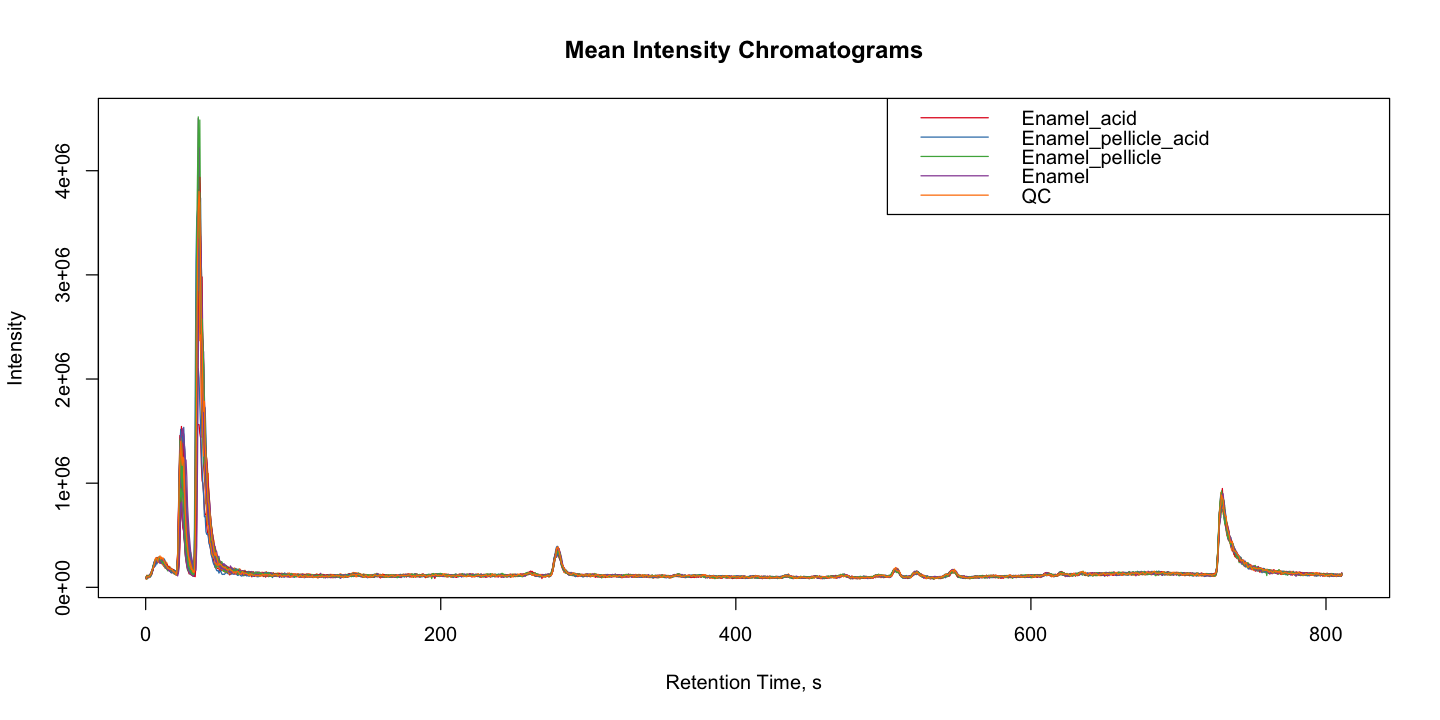

In [9]:
## Get mean intensity chromatograms
means <- chromatogram(raw, aggregationFun = "mean")

## Plot every mean intensity chromatogram of the data set
plot(means, col = group.colours[raw$sample_group], 
     main = "Mean Intensity Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

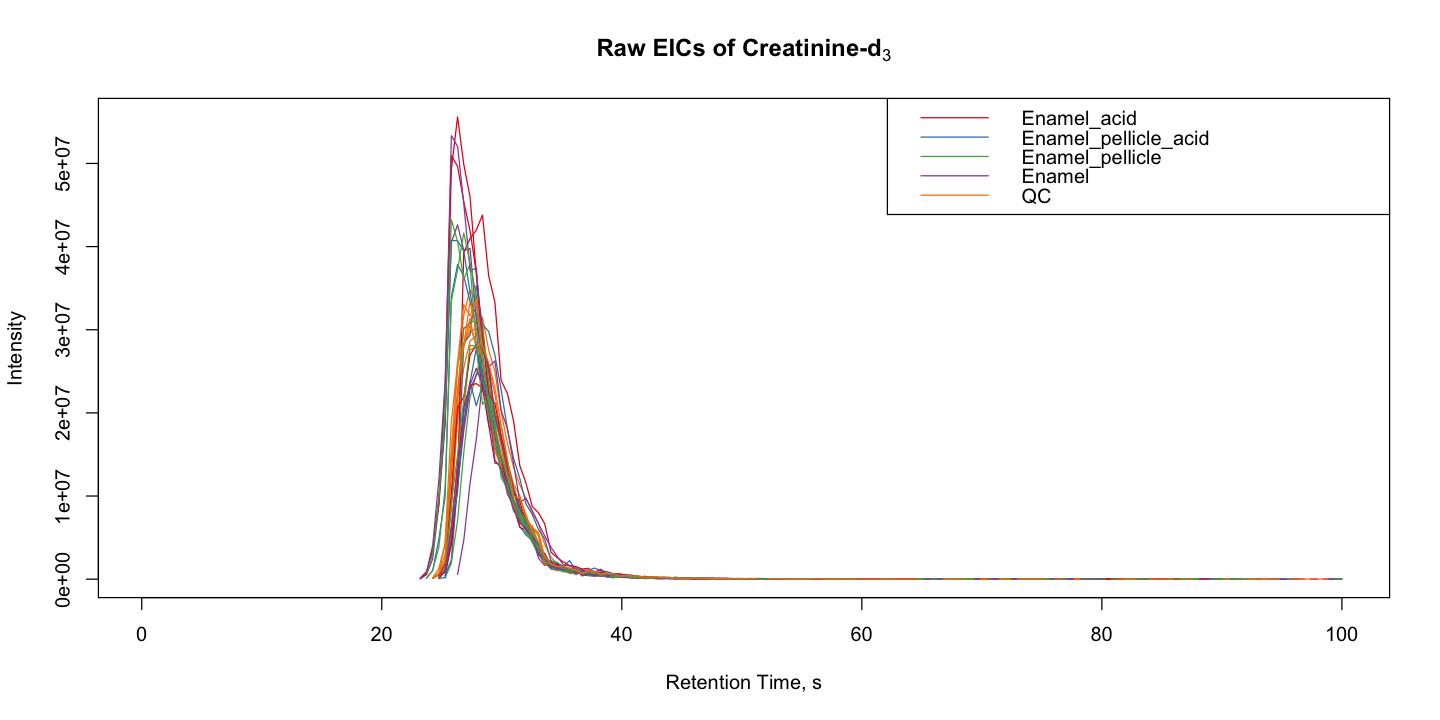

In [10]:
## Plot creatinine-d3 before processing
cread3.raw <- chromatogram(raw, mz = c(117.0845, 117.0856), rt = c(0, 100)) 

plot(cread3.raw, col = group.colours[cread3.raw$sample_group], 
     main = bquote(bold("Raw EICs of Creatinine-d"[3])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

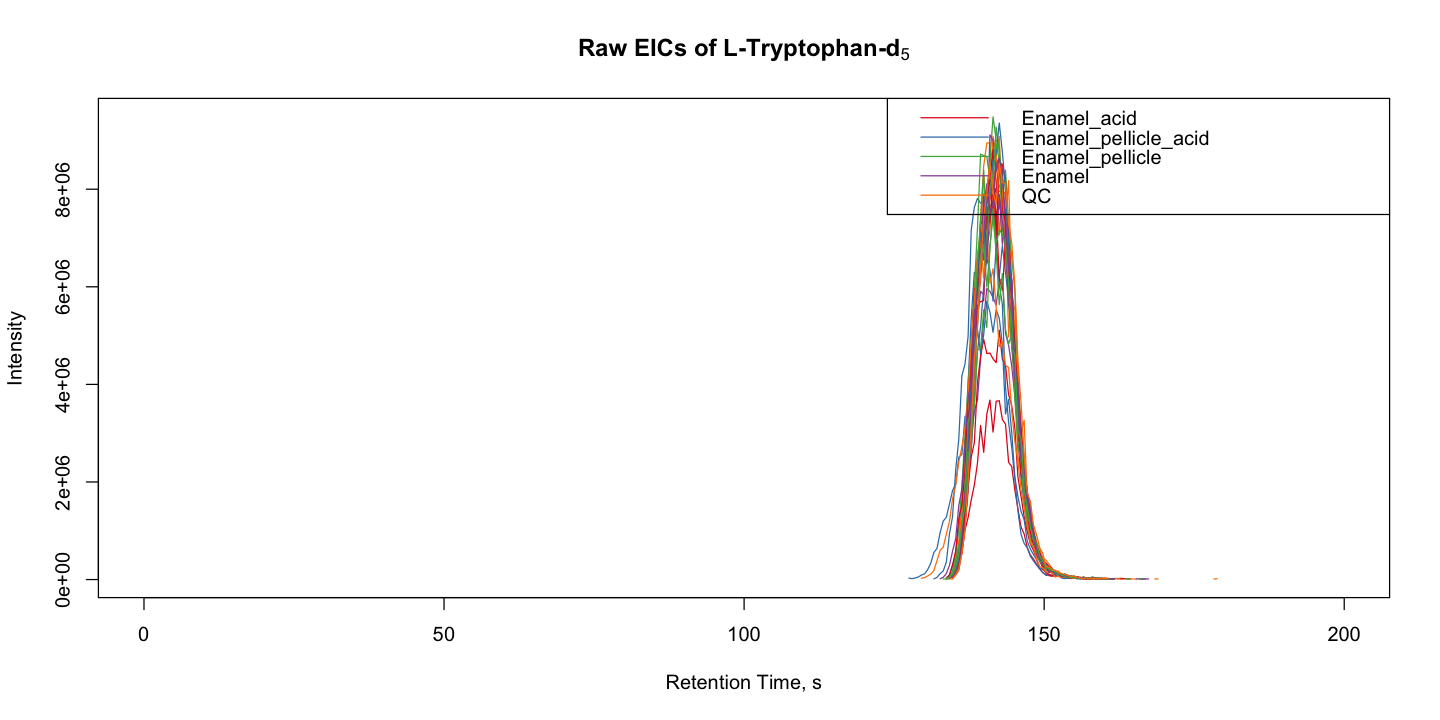

In [11]:
## Plot tryptophan-d5 before processing
trpd5.raw <- chromatogram(raw, mz = c(210.1275, 210.1295), rt = c(0, 200))

plot(trpd5.raw, col = group.colours[trpd5.raw$sample_group], 
     main = bquote(bold("Raw EICs of L-Tryptophan-d"[5])), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

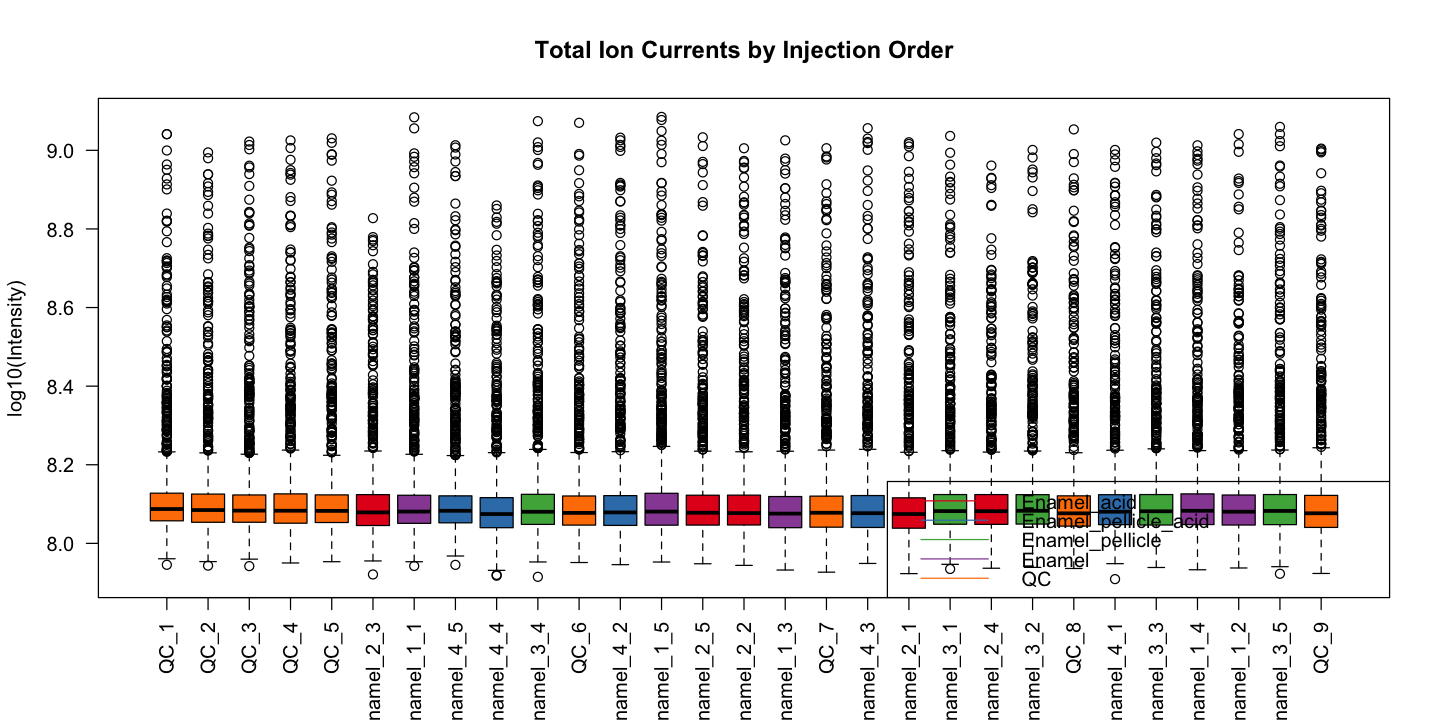

In [12]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

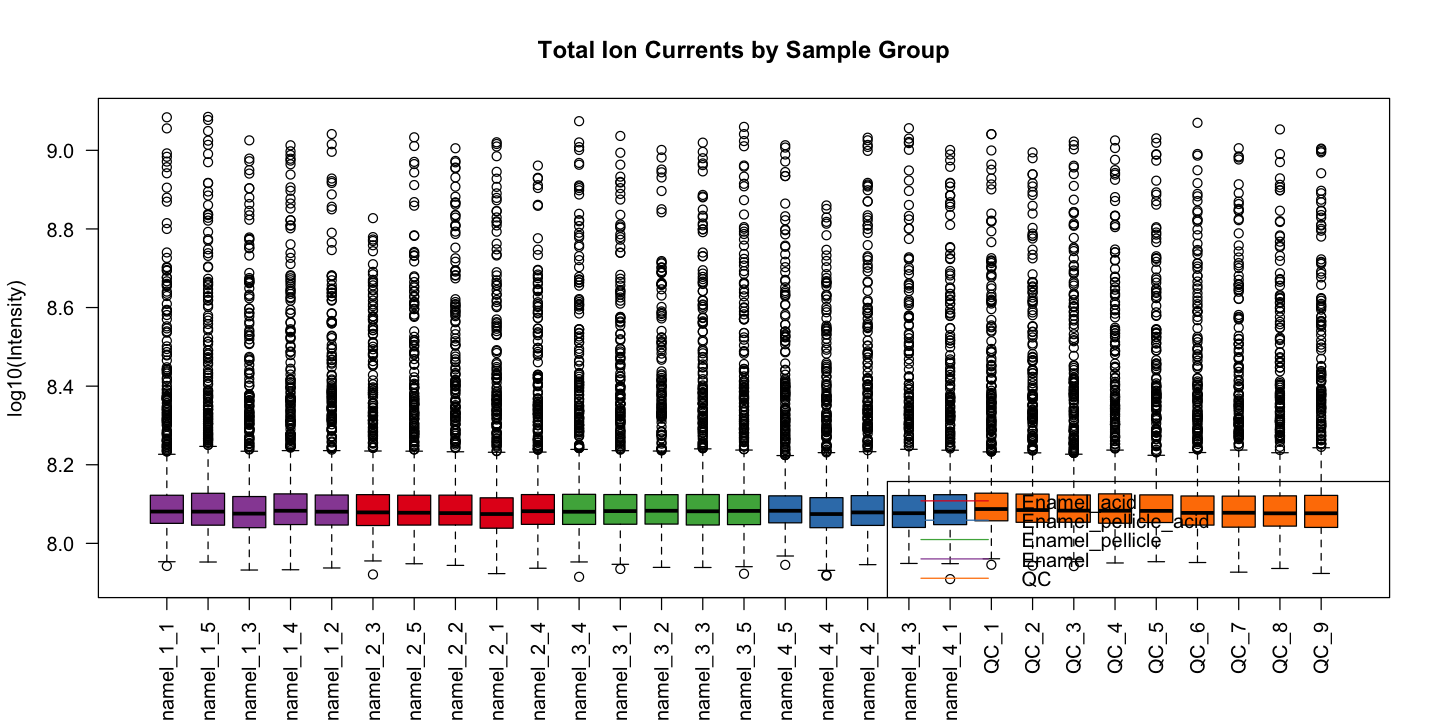

In [13]:
# Inspect boxplots of TICs by sample group
boxplot(sapply(tics.summary, log10)[,order(raw$sample_group)], 
        names = raw$sample_name[order(raw$sample_group)], 
        col = (group.colours[raw$sample_group])[order(raw$sample_group)], 
        ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Sample Group", las = 2)
legend("bottomright", legend = names(group.colours), col = group.colours, lty = 1)

## Preprocessing of Raw Sample Files

### Peak Picking
Parameter used in this section were obtained using the one-by-one optimization performed by [centWaveOpt](https://github.com/saskema/centWaveOpt). This approach was published at [DOI: 10.1002/dta.2552](https://doi.org/10.1002/dta.2552) by Manier et al.

In [15]:
cwp <- CentWaveParam(peakwidth = c(8.9, 12), ppm = 1.7, snthresh = 33, 
                     mzdiff = -0.002,  prefilter = c(5, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [16]:
## Define sample colours
sample.colours <- paste0(brewer.pal(5, "Set1")[1:5])
names(sample.colours) <- c("Enamel_acid","Enamel_pellicle_acid","Enamel_pellicle","Enamel", "QC")
sample.colours <- sample.colours[raw$sample_group]

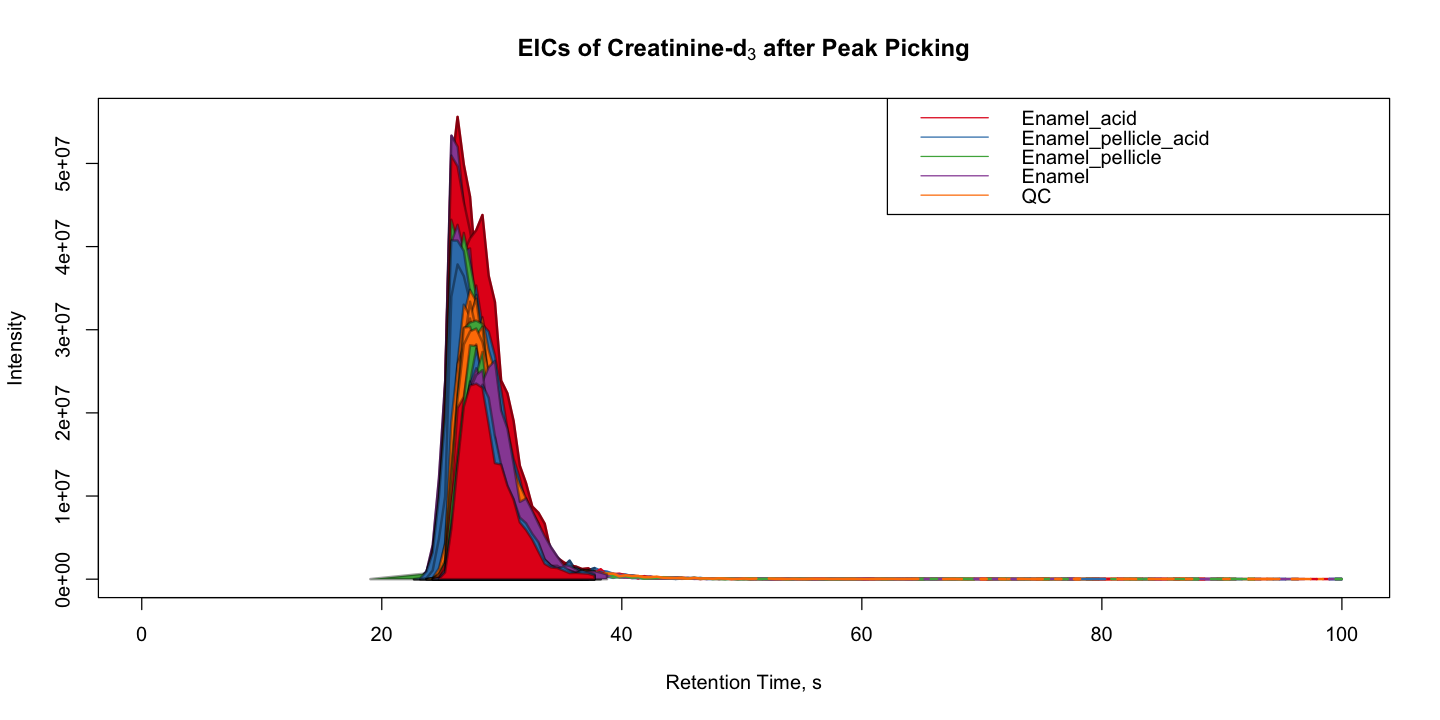

In [17]:
## Plot creatinine-d3 after peak picking
cread3.picked <- chromatogram(set, mz = c(117.0845, 117.0856), rt = c(0, 100)) 

plot(cread3.picked, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.picked)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

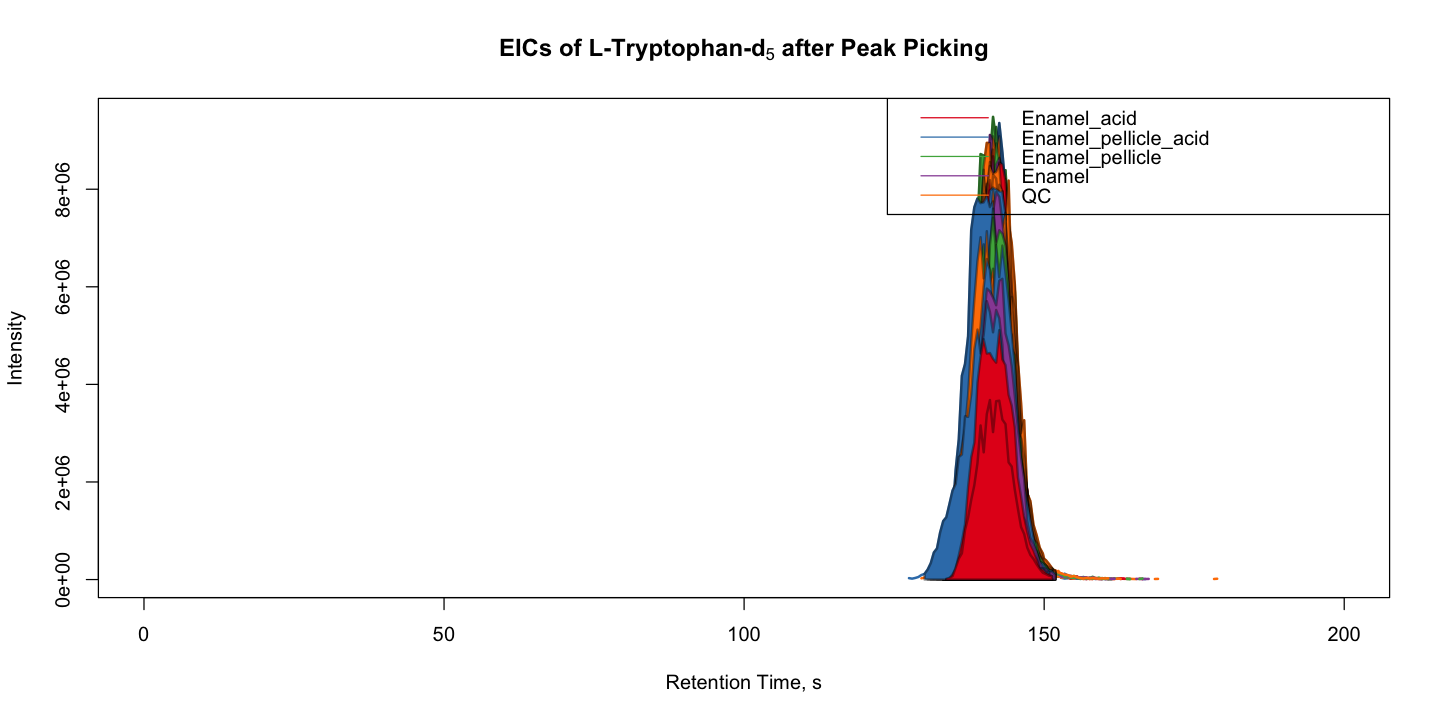

In [18]:
## Plot Tryptophan-d5 after peak picking
trpd5.picked <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(0, 200)) 

plot(trpd5.picked, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.picked)[, "sample"]],
     main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Peak Picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Retention Time Correction (RT)

In [31]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.2))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 0.4)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.85, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.4)
    set <- adjustRtime(set, param = pgp)
    
})

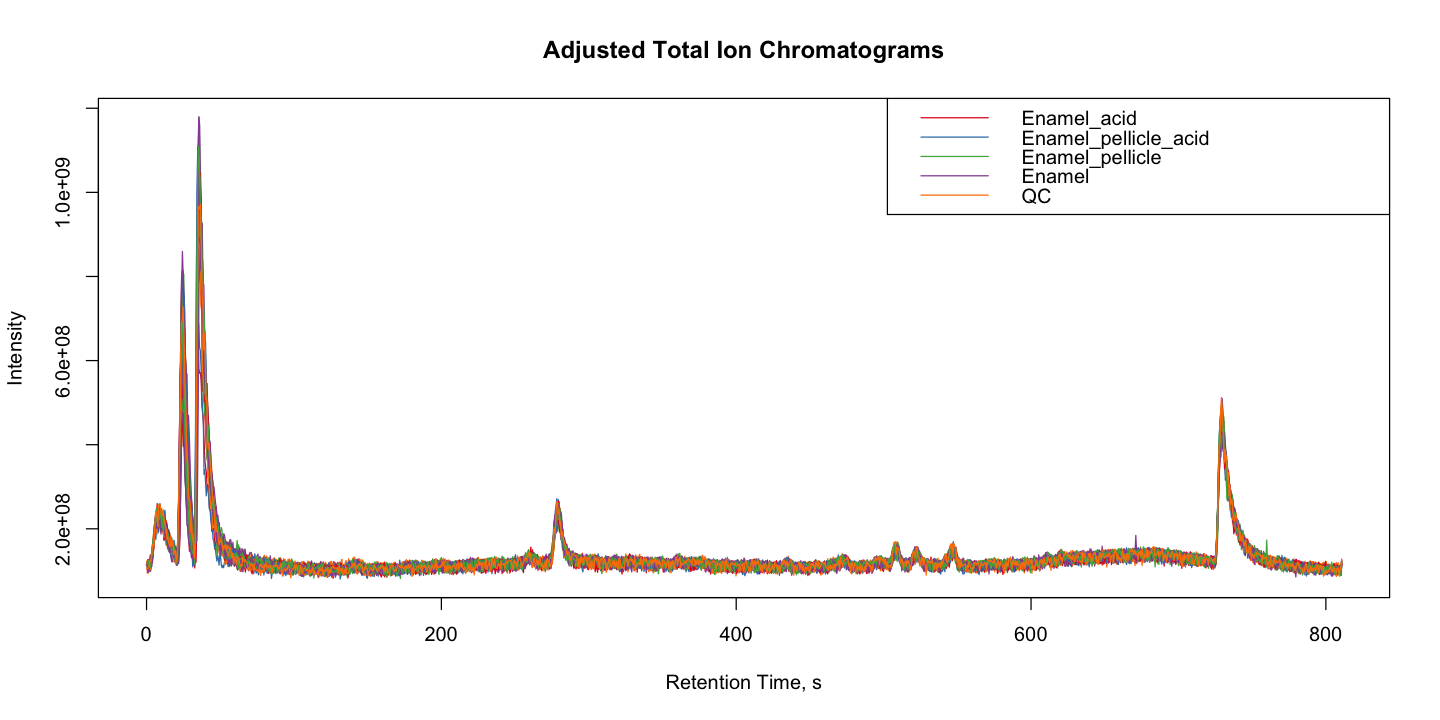

In [32]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

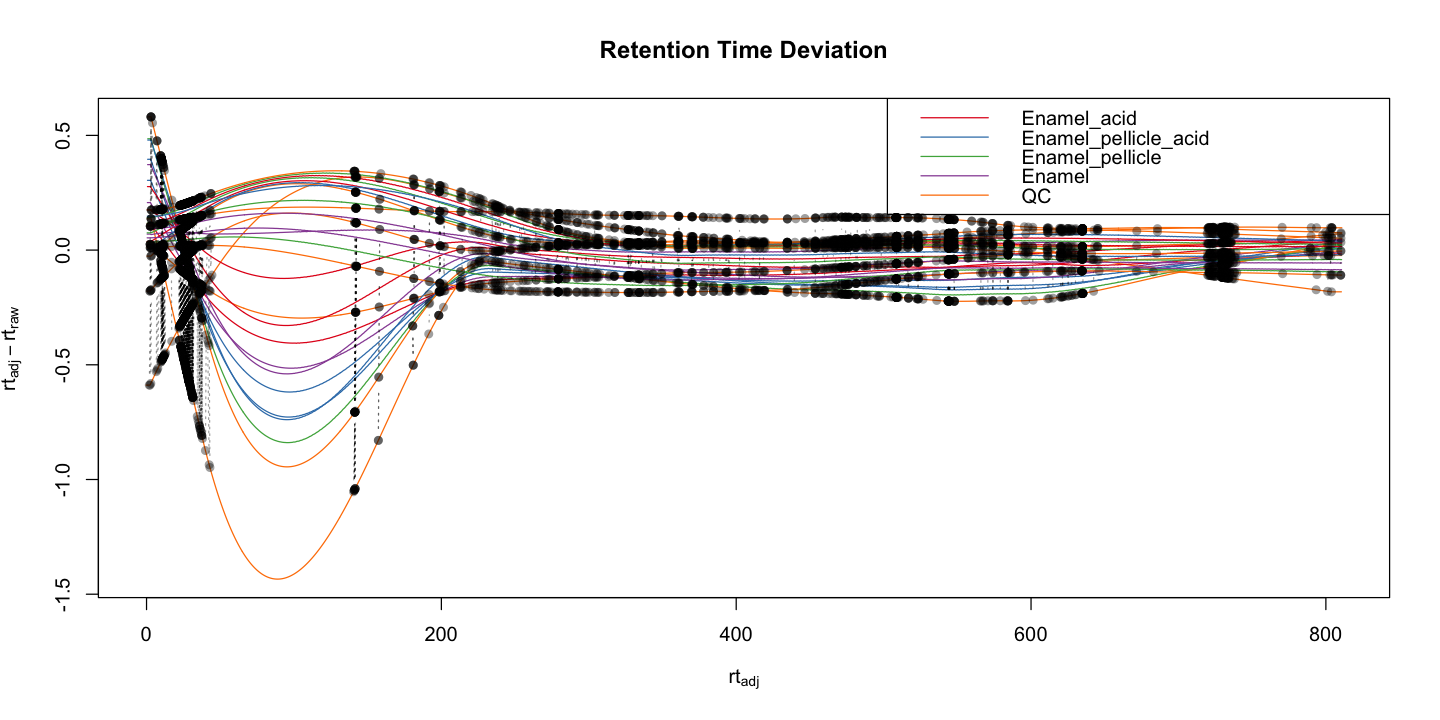

In [33]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

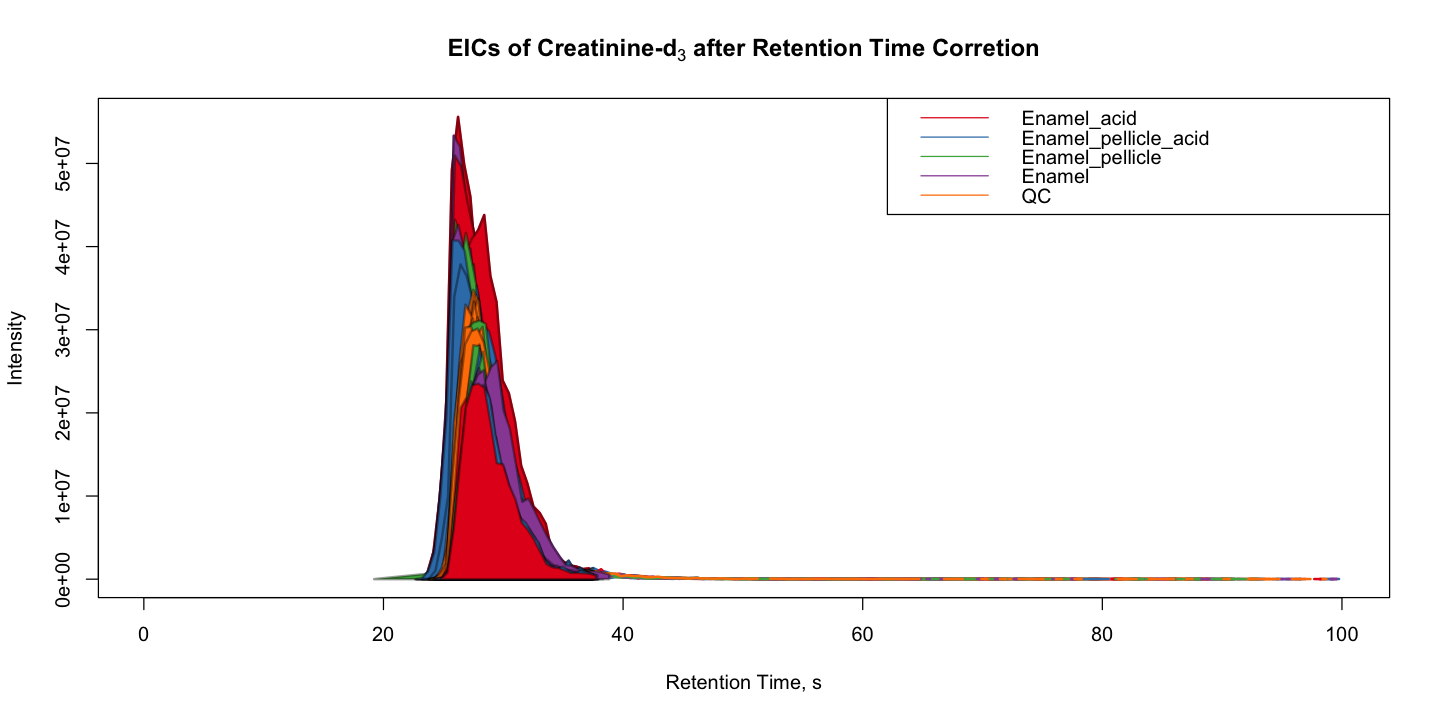

In [34]:
## Plot creatinine-d3 after retention time correction
cread3.corr <- chromatogram(set, mz = c(117.0845, 117.0856), rt = c(0, 100)) 

plot(cread3.corr, col = group.colours[cread3.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(cread3.corr)[, "sample"]],
     main = bquote(bold("EICs of Creatinine-d"[3]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

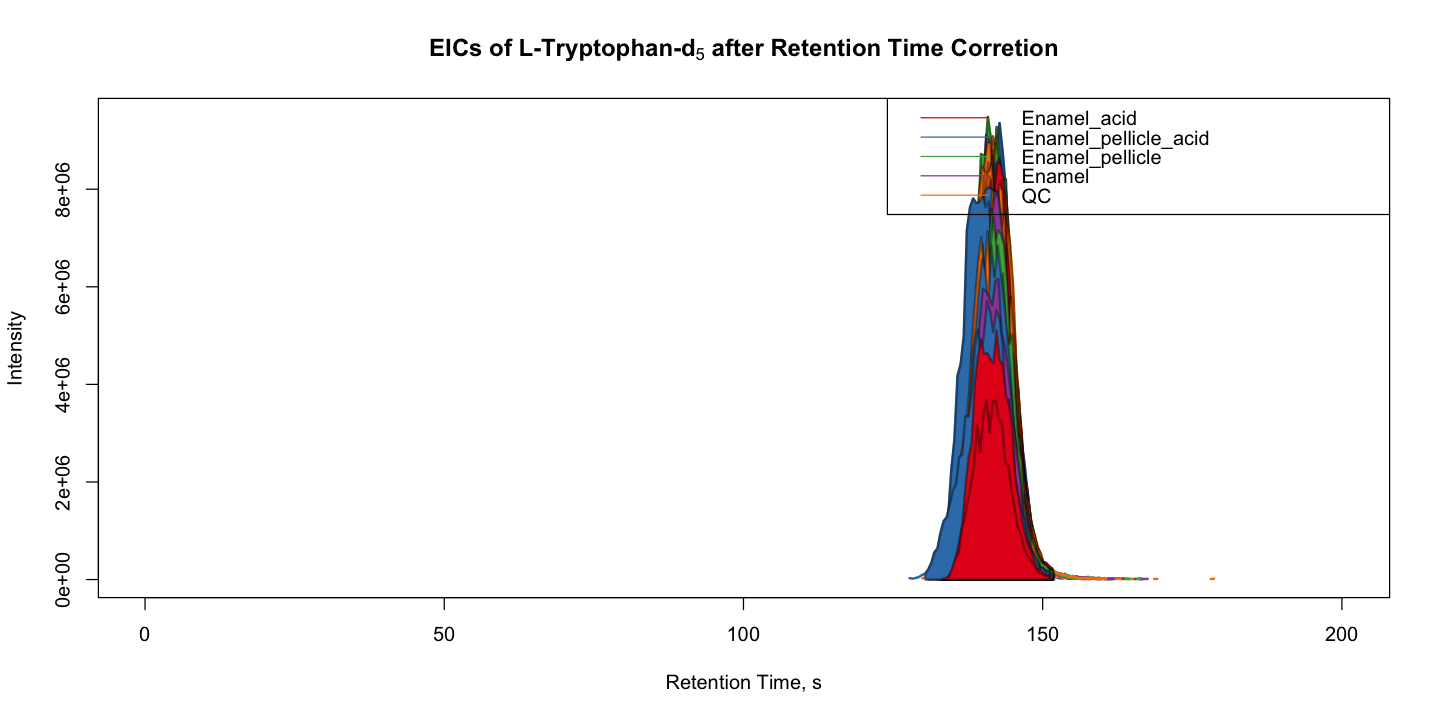

In [35]:
## Plot tryptophan-d5 after retention time correction
trpd5.corr <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(0, 200)) 

plot(trpd5.corr, col = group.colours[trpd5.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(trpd5.corr)[, "sample"]],
     main = bquote(bold("EICs of L-Tryptophan-d"[5]*" after Retention Time Corretion")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

### Peak Grouping

In [36]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

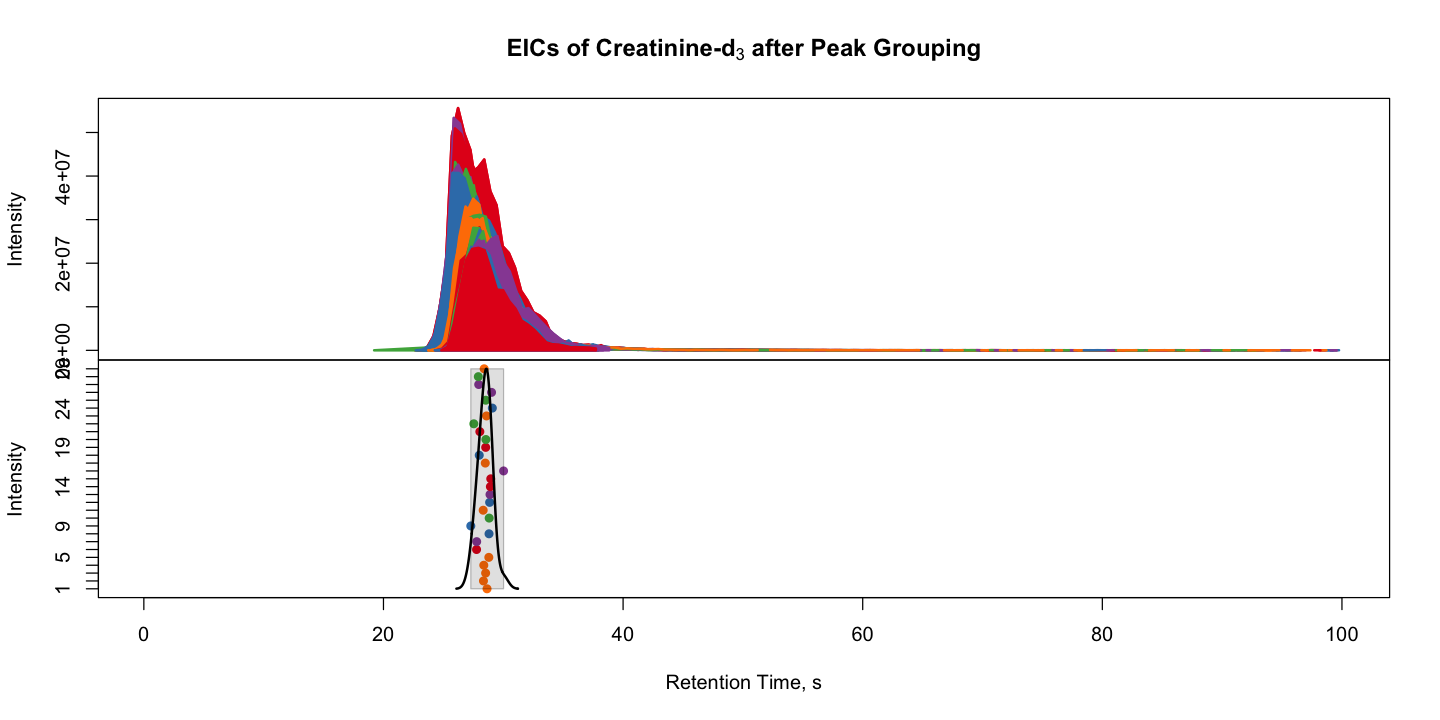

In [37]:
## Plot creatinine-d3 after peak grouping
cread3.grouped <- chromatogram(set, mz = c(117.0851, 117.0861), rt = c(0, 100))

## Define the parameters for the peak density method
plotChromPeakDensity(cread3.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(cread3.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Creatinine-d"[3]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

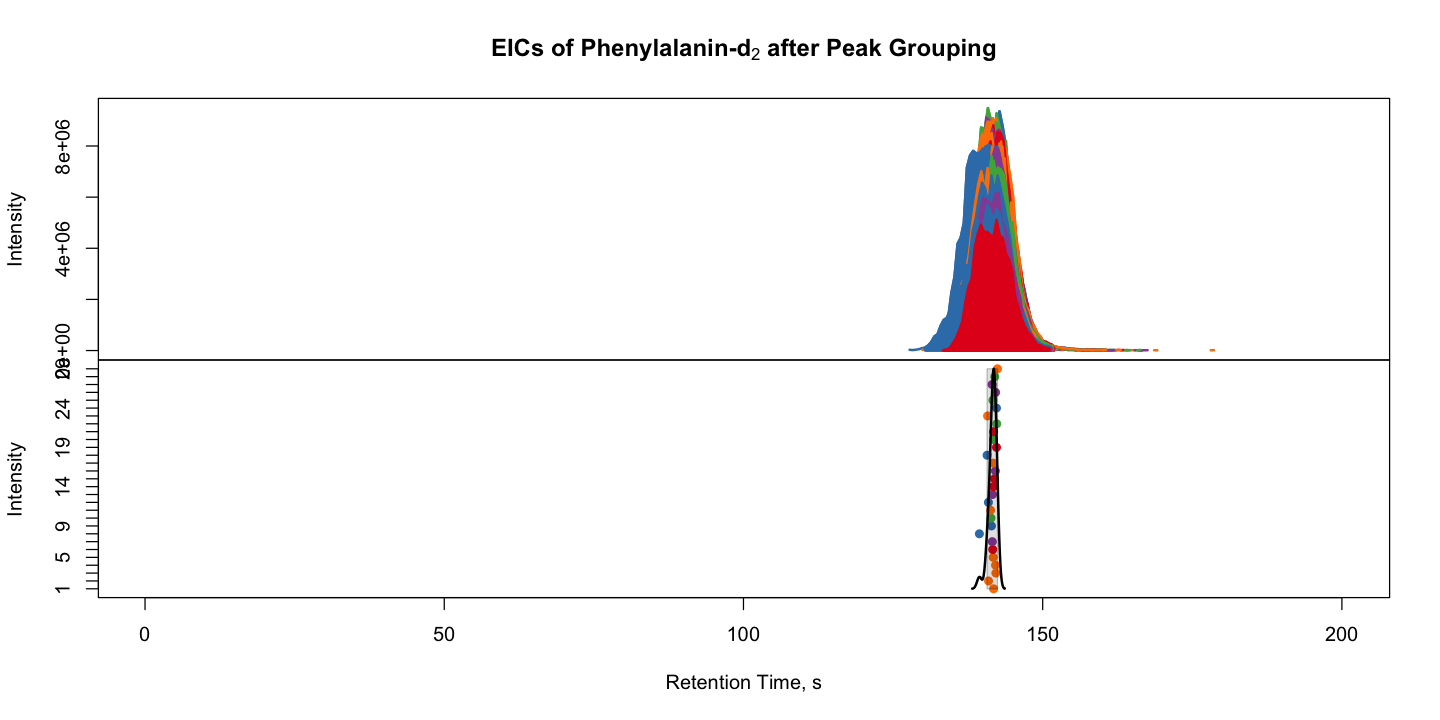

In [38]:
## Plot tryptophan-d5 after peak grouping
phenyld2.grouped <- chromatogram(set, mz = c(210.1275, 210.1295), rt = c(0, 200))

## Define the parameters for the peak density method
plotChromPeakDensity(phenyld2.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(phenyld2.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(phenyld2.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of Phenylalanin-d"[2]*" after Peak Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

### Peak Filling

In [39]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

## Post Processing

### Export Results to SummarizedExperiment-Object

In [40]:
## Summarise experiment
results <- quantify(set, value = "into")

In [41]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))

### Annotation of Adducts and Isotopes

In [42]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 138 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  40  50  60  70  80  90  100  
Found isotopes: 151 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 138 Groups... 
 % finished: 10  20  40  50  60  70  80  90  100  

Calculating graph cross linking in 138 Groups... 
 % finished: 10  20  40  50  60  70  80  90  100  
New number of ps-groups:  368 
xsAnnotate has now 368 groups, instead of 138 
Generating peak matrix for peak annotation!

Calculating possible adducts in 368 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


### Scaling
Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at [DOI: 10.1007/s11306-016-1015-8](https://doi.org/10.1007/s11306-016-1015-8). The surrogate LOD is the lowest area that was measured during the analysis.

In [43]:
# Replacing NAs with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

In [44]:
# Create separate (scaled) assay results within same object
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

# Normalisation

In [45]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

### Batch correction

In [46]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [47]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$analysis_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

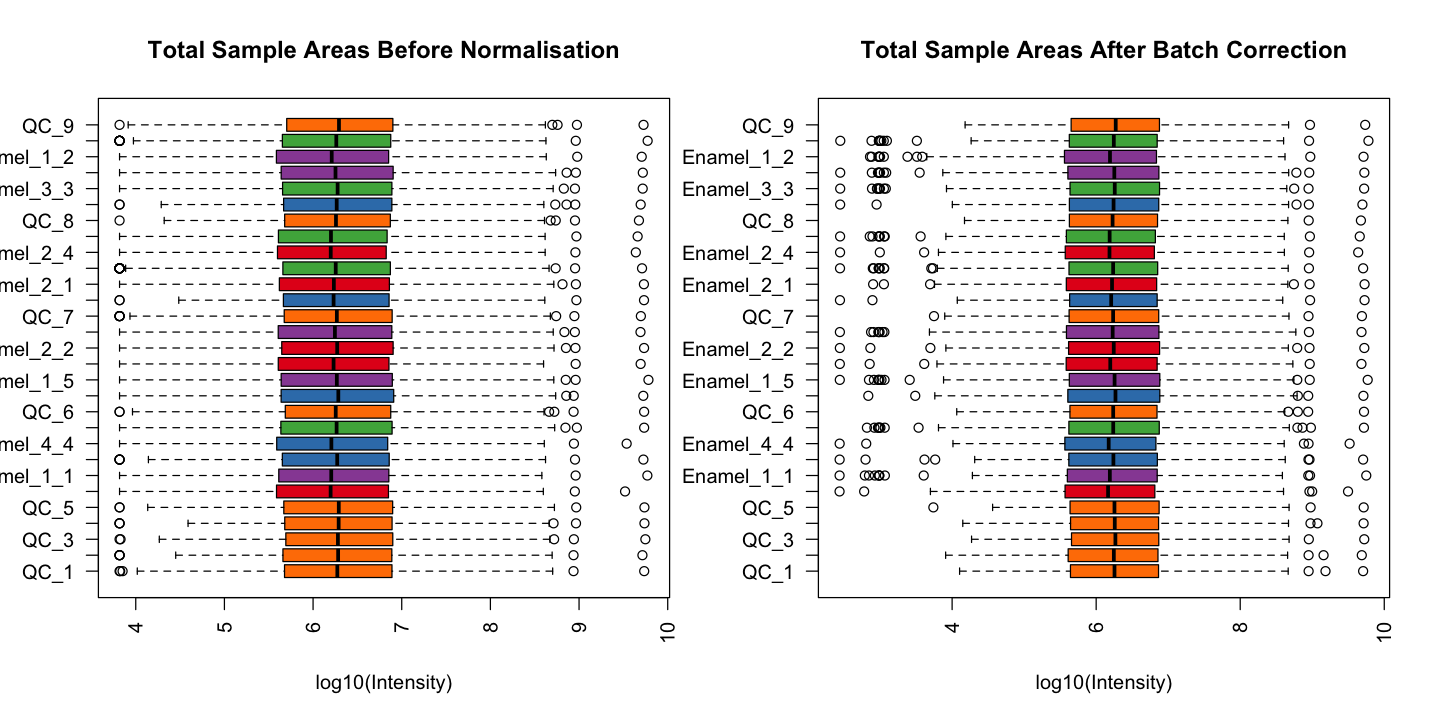

In [48]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

## Statistical Evaluation

In [49]:
## Define results column
rowData(results)$pvalue <- NA

## Calculate ANOVA for each feature
anova.table <- results[,results$sample_group != "QC"] %>%
               assay("batchcorr") %>%
               t()
anova.factor <- results$sample_group[results$sample_group != "QC"]

for(i in 1:ncol(anova.table)) {
        
    sum <- aov(anova.table[,i]~anova.factor) %>%
           summary() %>%
           unlist()
    rowData(results)$pvalue[i] <- sum["Pr(>F)1"]
    
    }

## Evaluate p-values
rowData(results)$significant <- ifelse(rowData(results)$pvalue < 0.005,
                                       TRUE, FALSE)

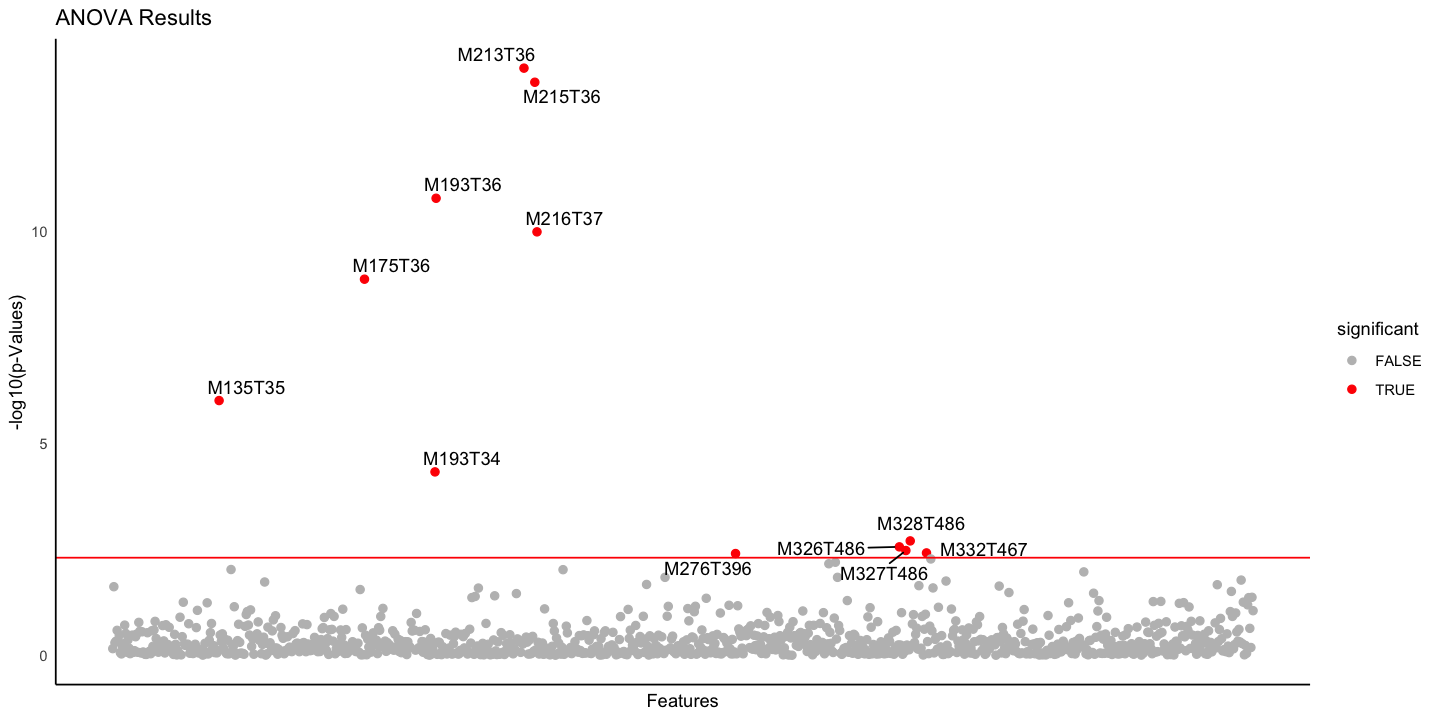

In [50]:
coloursBoolean <- c("TRUE" = "red", "FALSE" = "grey")

results %>%
rowData() %>%
as.data.frame %>%
ggplot(aes(x = 1:nrow(rowData(results)), y = -log10(pvalue),
           label = ifelse(rowData(results)$significant, 
                          rowData(results)$label, ""), colour = significant)) +
geom_point(size = 2) +
scale_color_manual(values = coloursBoolean) +
geom_hline(yintercept = -log10(0.005), colour = "red") +
geom_text_repel(point.padding = 0.2, colour = "black") +
ggtitle("ANOVA Results") +
xlab("Features") +
ylab("-log10(p-Values)") +
theme_classic() +
theme(axis.text.x = element_blank(),
      axis.ticks = element_blank())

### Evaluate Significance

In [51]:
results.filtered <- results[rowData(results)$significant == TRUE,]

### Hierarchical Clustering

In [52]:
## Calculate row and column cluster
r.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

c.cluster <- results.filtered %>%
             assay("batchcorr") %>%
             t() %>%
             dist(method = "manhattan") %>%
             hclust(method = "complete") %>%
             as.dendrogram()

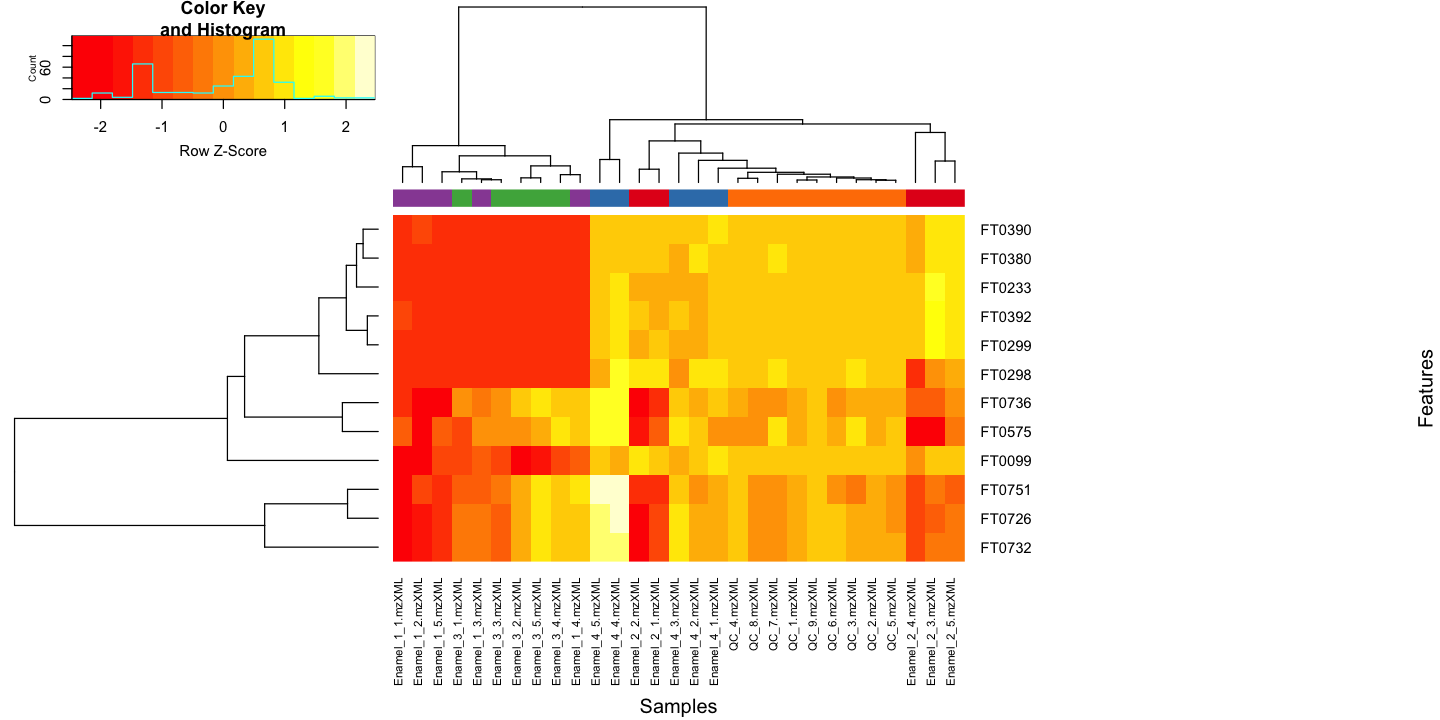

In [53]:
## Plot results of hierarchical clustering
results.filtered %>%
assay("batchcorr") %>%
heatmap.2(scale = "row", margins = c(10,30), trace = "none", 
          Rowv = r.cluster, Colv = c.cluster, ColSideColors = group.colours[results$sample_group],
         xlab = "Samples", ylab = "Features")

### t-SNE

In [54]:
## Perform t-SNE
tsne <- results.filtered %>%
        assay("batchcorr") %>%
        t() %>%
        Rtsne(dim = 2, perplexity = 4, 
              epoch = 100,verbose = FALSE, 
              pca_center = TRUE, pca_scale = FALSE)

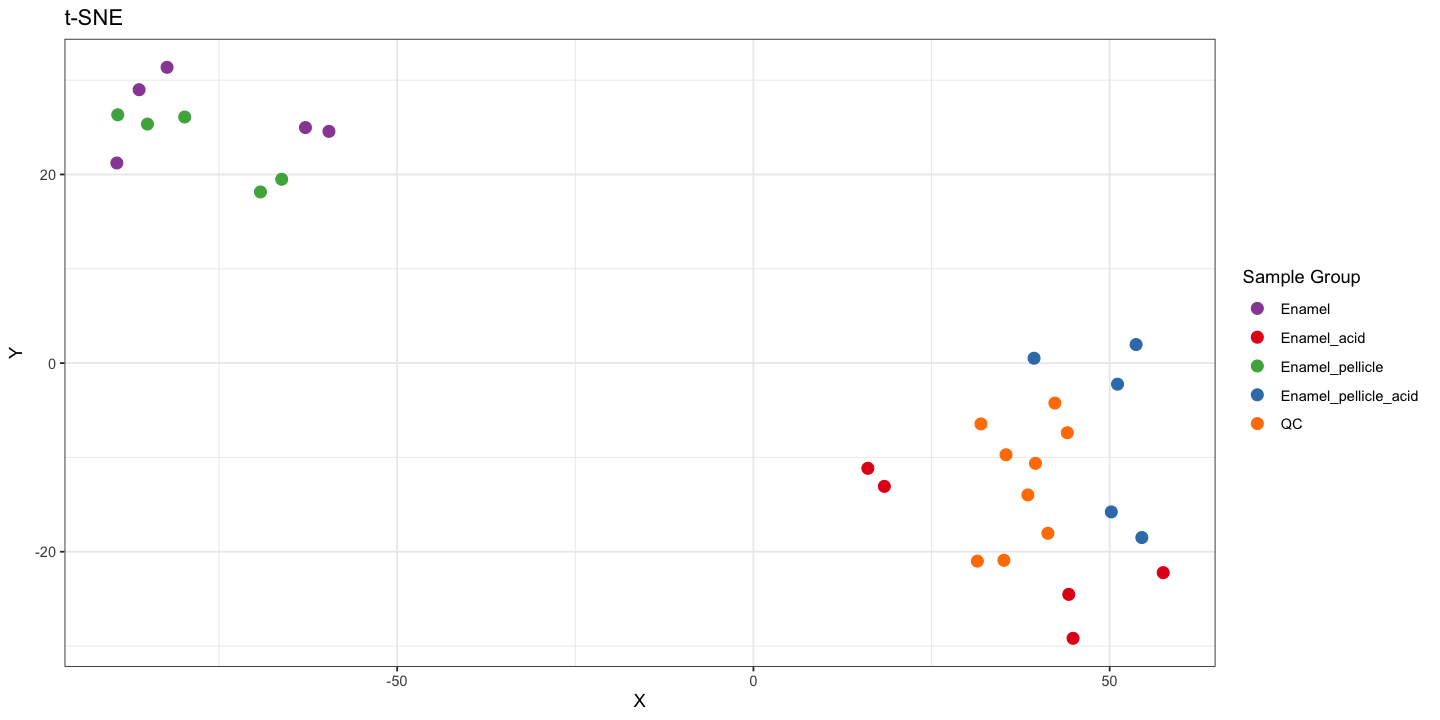

In [55]:
tsne$Y %>%
as.data.frame() %>%
ggplot(aes(x = V1, y = V2, col = results.filtered$sample_group)) +
geom_point(size = 3) +
labs(fill="Sample Group") +
scale_color_manual("Sample Group", values = group.colours) +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
ggtitle("t-SNE") +
xlab("X") +
ylab("Y") +
theme_bw()

### Principal Component Analysis

In [56]:
## Perform PCA of significant features
pca <- results.filtered %>%
       assay("batchcorr") %>%
       t() %>%
       prcomp(center = TRUE)

## Perform summary of PCA characteristics
pca.summary <- summary(pca)
var <- results.filtered %>%
       assay("batchcorr") %>%
       var()
eig <- pca$sdev^2
kaiser <- length(which(eig > mean(eig)))
jolliffe <- length(which(eig > (0.7*mean(eig))))
scree <- data.frame(PC = seq(from = 1, to = length(eig), by = 1),
                    Eigenvalue = eig/sum(eig))
scree$Importance <- pca.summary$importance[3,]
scree <- reshape(data = scree, direction = "long",
                     varying = c("Eigenvalue", "Importance"),
                     v.names = "Value", idvar = "PC",
                     timevar = "Characteristic",
                     times = c("Eigenvalue", "Importance"))

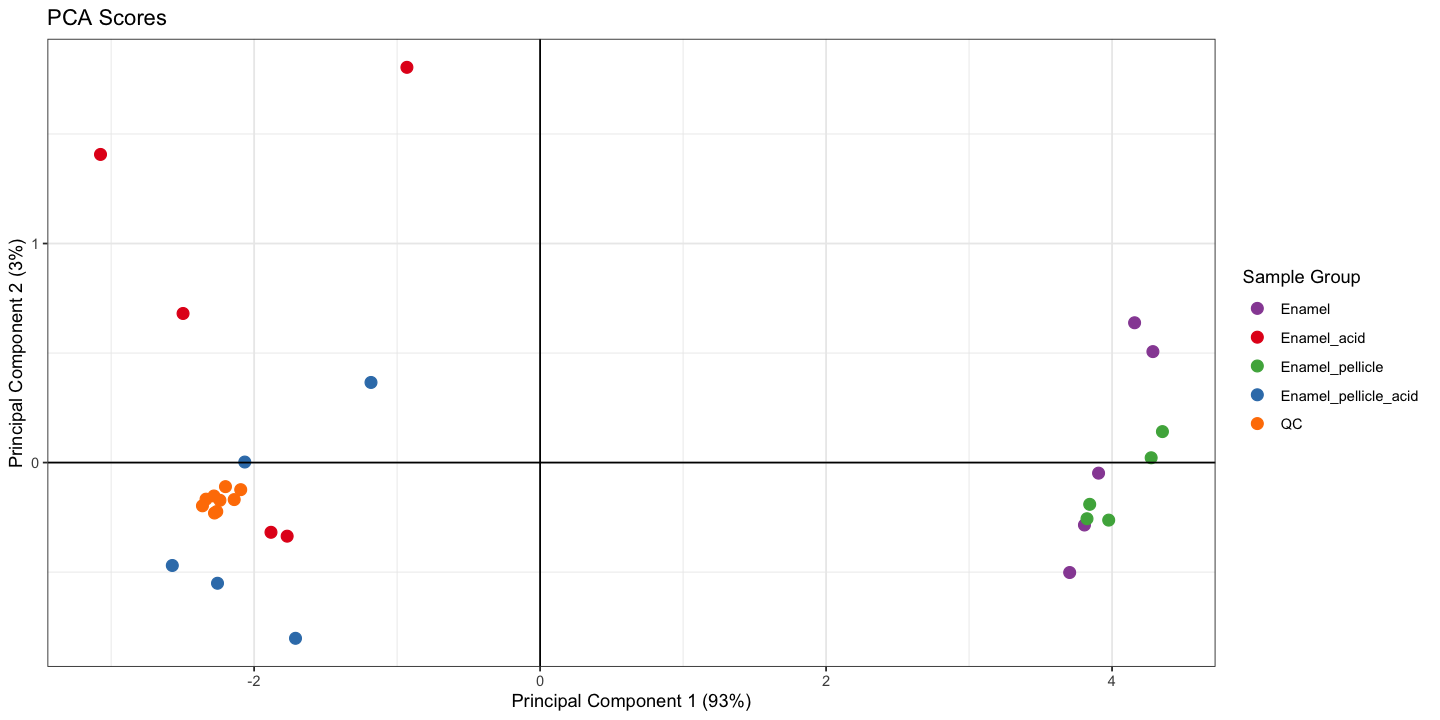

In [57]:
## Plot PCA scores
pca$x %>%
as.data.frame %>%
ggplot(aes(x = PC1, y = PC2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +          
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Scores") +
#geom_text(aes(label = rownames(pca$x)), vjust = -0.5, hjust = 0.5) +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw() 

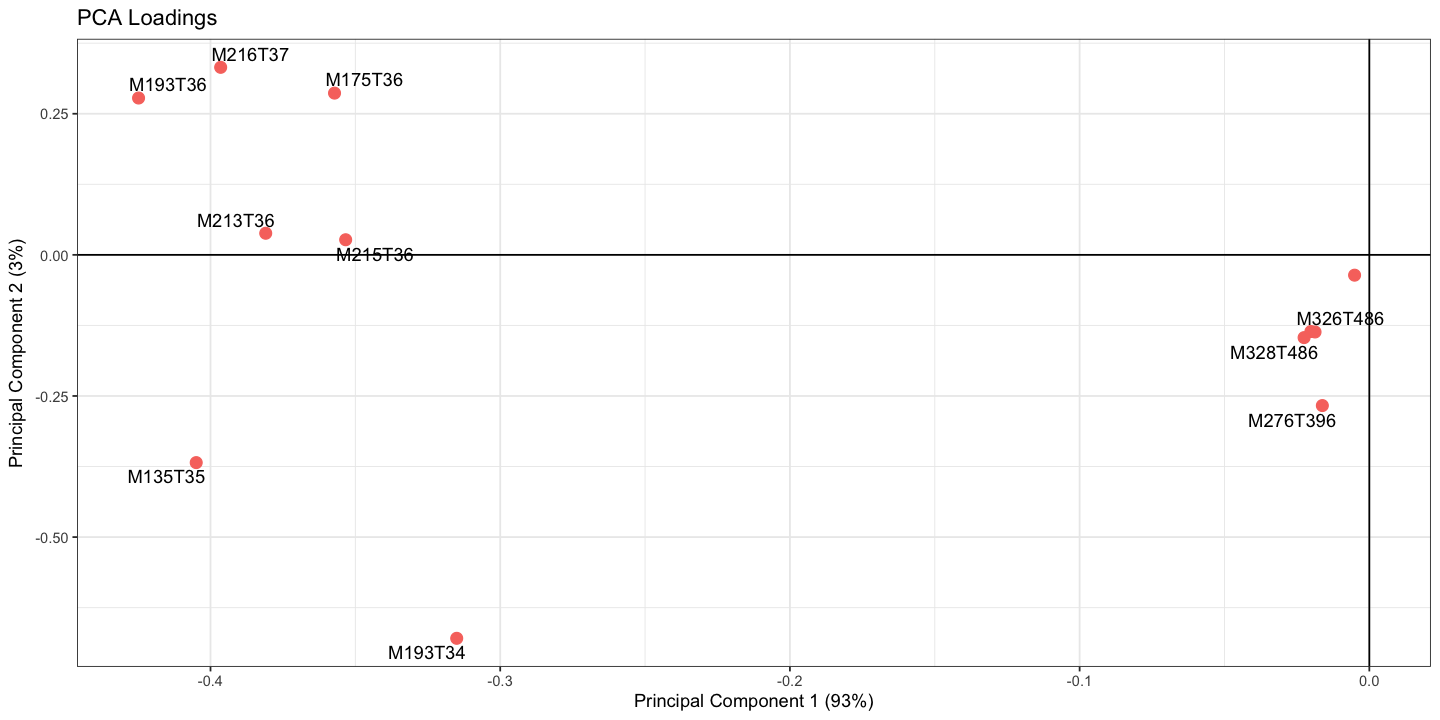

In [58]:
## Plot PCA loadings
pca$rotation %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = sqrt((pca$rotation[,1])^2 + (pca$rotation[,2])^2)) %>%
ggplot(aes(x = PC1, y = PC2,
           label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[10], label, ""))) +
geom_point(size = 3, show.legend = FALSE, aes(col = "red")) +
geom_text_repel(point.padding = 0.2) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle("PCA Loadings") +
xlab(paste0("Principal Component 1", " ", "(", 
            round(pca.summary$importance[2,1]*100, 0), "%)")) +
ylab(paste0("Principal Component 2", " ", "(", 
            round(pca.summary$importance[2,2]*100, 0), "%)")) +
theme_bw()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


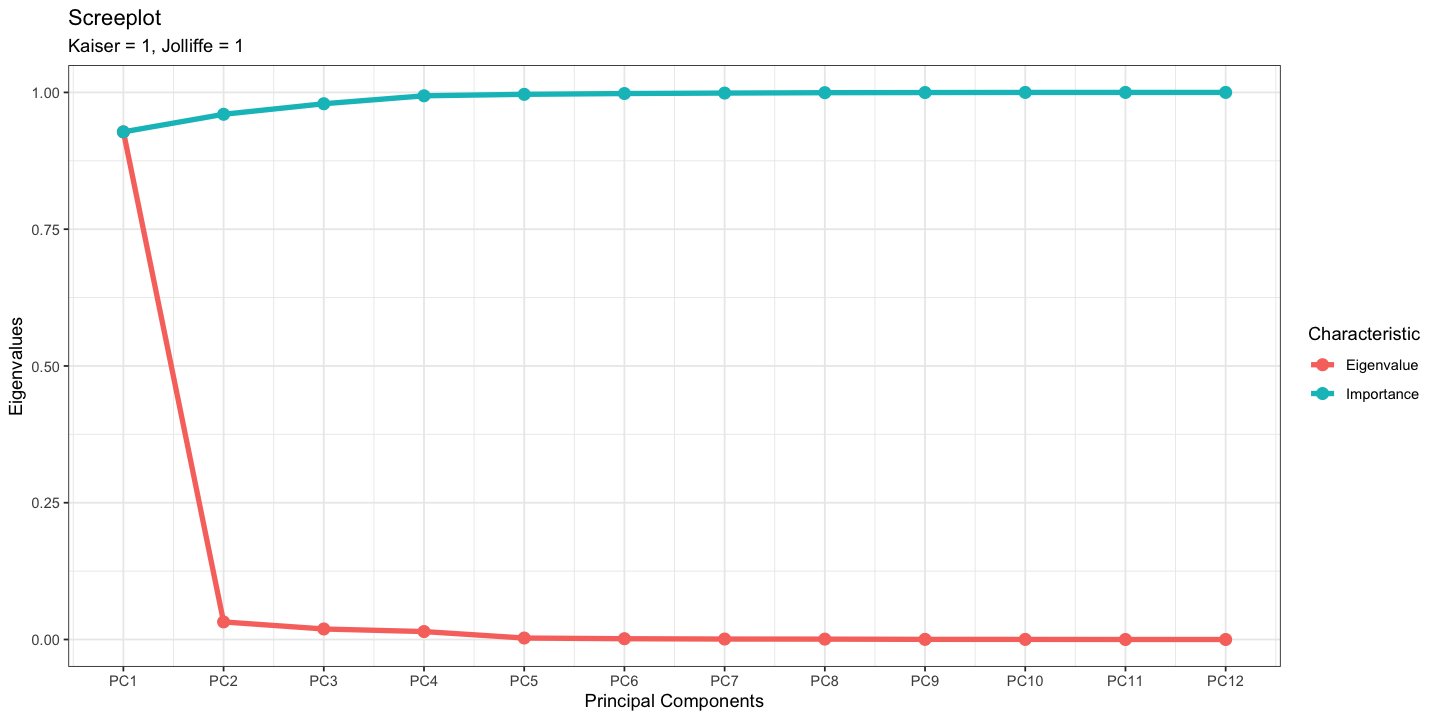

In [59]:
scree %>%
ggplot(aes(x = PC, y = Value, group = Characteristic,
                                     colour = Characteristic)) +        
geom_line(size = 1.5) +
geom_point(size = 3) +
scale_x_continuous(breaks = unique(scree$PC), labels = colnames(pca$rotation)) +
ggtitle(label = "Screeplot",
        subtitle = paste0("Kaiser = ", kaiser, ", Jolliffe = ", jolliffe)) +
xlab("Principal Components") +
ylab("Eigenvalues") +
theme_bw()

### PC-LDA

In [60]:
## Determine number of PCs for LDA
n.pc <- length(which(pca$sdev^2 > mean(pca$sdev^2)))
n.pc <- ifelse(n.pc < 3, 3, n.pc)

## Perform LDA and calculate new loadings
pc.ldam <- pca$x[,1:n.pc] %>%
           as.matrix() %>%
           lda(results$sample_group)

pc.lda.loadings <- pca$rotation[,1:n.pc] %*% pc.ldam$scaling

# Calculate aboslute loading and save to results
rowData(results.filtered)$abs_loading <- sqrt(abs(pc.lda.loadings[,1])^2 + 
                                     abs(pc.lda.loadings[,2])^2)

## Calculate prediction accuracy and cohens kappa
monte.carlo <- train(pca$x[,1:n.pc], results.filtered$sample_group,
                     method = "lda",
                     trControl = trainControl(method = "LGOCV"))
cvaccuracy <- as.numeric(round(monte.carlo$results[2]*100, 0))
cvkappa <- as.numeric(round(monte.carlo$results[3]*100, 0))
    
## Predict model for test data
p <- predict(pc.ldam, as.data.frame(pca$x[,1:n.pc]))

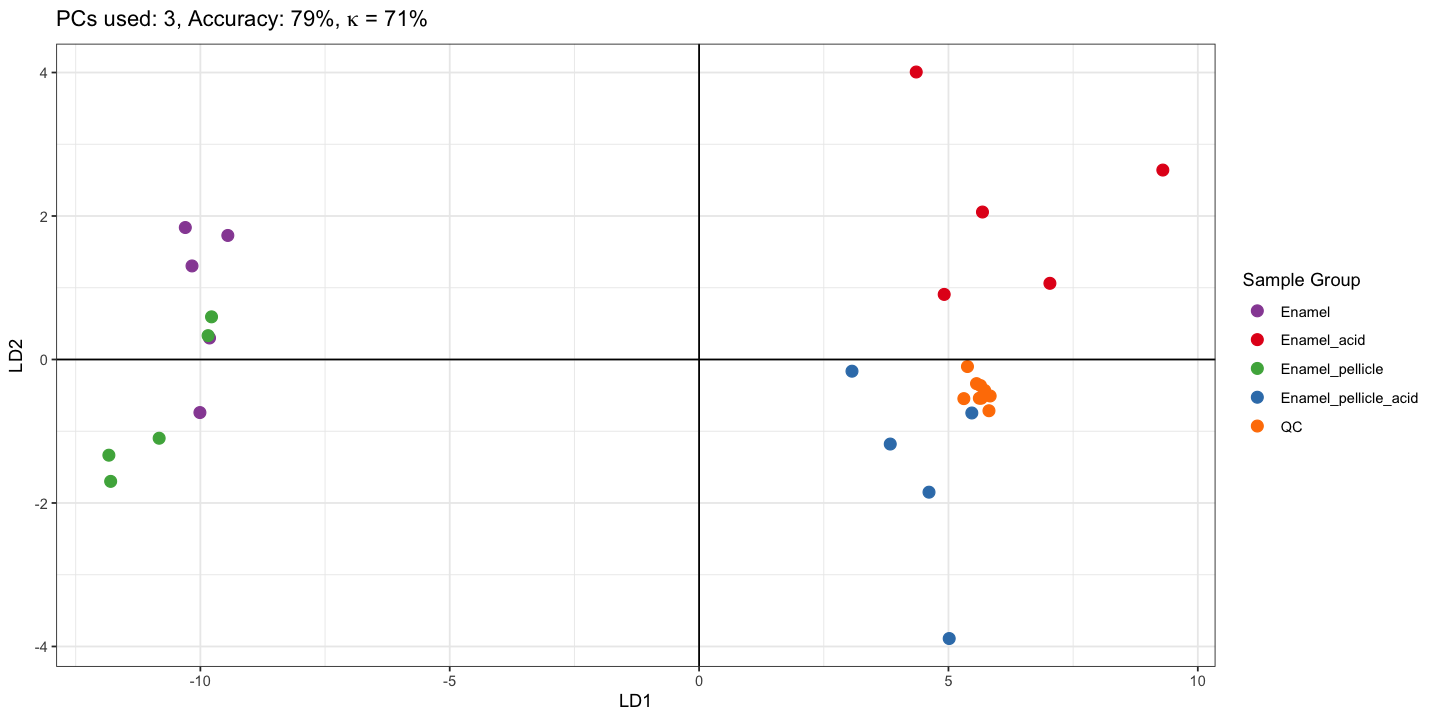

In [61]:
## Plot PC-LDA scores
p$x %>%
as.data.frame() %>%
ggplot(aes(x = LD1, y = LD2)) +
geom_point(size = 3, aes(col = results.filtered$sample_group)) +
scale_color_manual("Sample Group", values = group.colours) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", 
                         cvacc, "%, ", kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


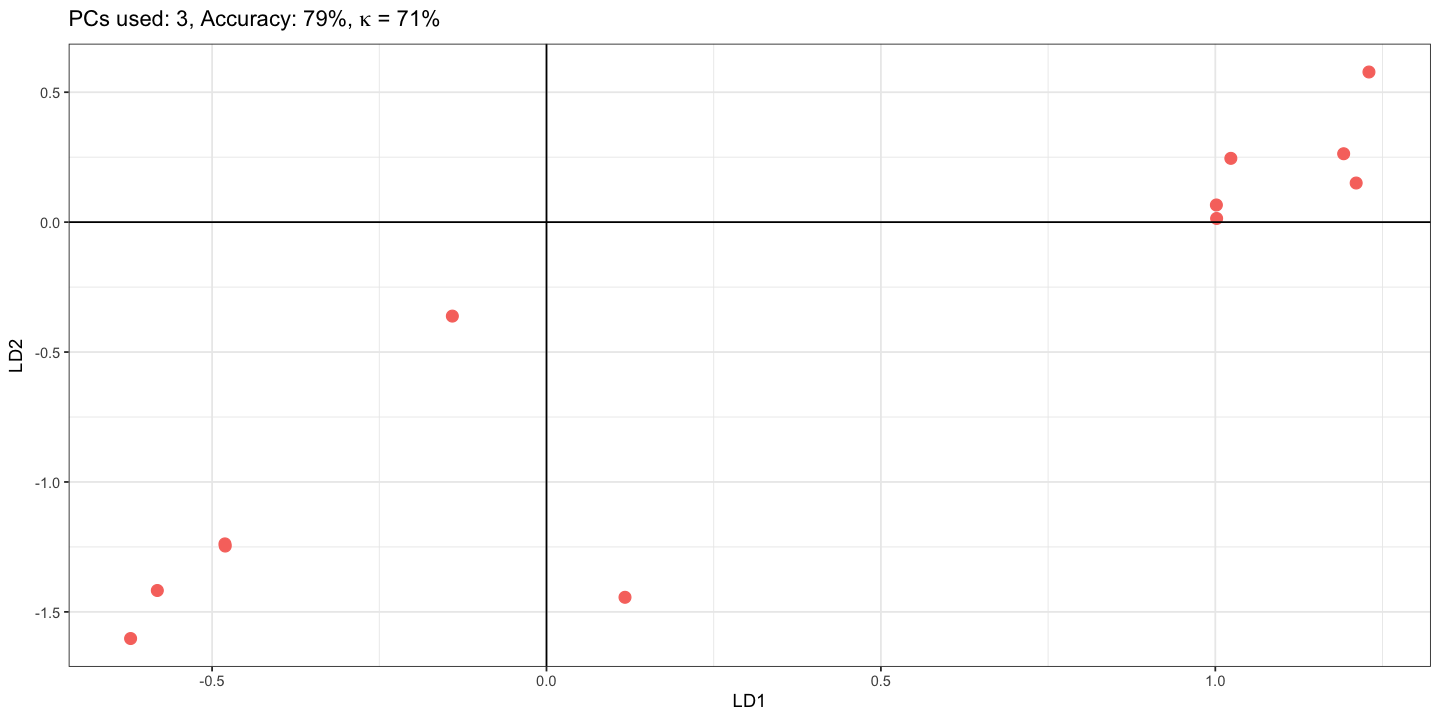

In [62]:
## Plot PCA loadings
pc.lda.loadings %>%
data.frame(label = rowData(results.filtered)$label, 
           abs_loading = rowData(results.filtered)$abs_loading) %>%
ggplot(aes(x = LD1, y = LD2, label = ifelse(abs_loading >= sort(abs_loading, 
                                              decreasing = TRUE)[15], label, ""))) +
geom_point(size = 3, aes(col = "red"), show.legend = FALSE) +
geom_hline(yintercept = 0) +
geom_vline(xintercept = 0) +
geom_text_repel(point.padding = 0.2) +
ggtitle(substitute(paste("PCs used: ", n_pc, ", ", "Accuracy: ", cvacc, "%, ",
                         kappa, " = ", cvka, "%"),
                   list(n_pc = n.pc, cvacc = cvaccuracy, cvka = cvkappa))) +
theme_bw()

## Summarise significant features to a table

In [65]:
summary <- results.filtered %>%
           rowData() %>%
           as.data.frame() %>%
           filter(significant == TRUE) %>%
           dplyr::select(label, mzmed, rtmed, pvalue, abs_loading,
                         isotopes, adduct, pcgroup) %>%
           arrange(desc(abs_loading))
summary[1:12,]

,label,mzmed,rtmed,pvalue,abs_loading,isotopes,adduct,pcgroup
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
FT0736,M328T486,328.3852,486.17208,2.009199e-03,1.7189874,[67][M+2]+,,40
FT0575,M276T396,276.2689,396.27558,3.989210e-03,1.5324829,,,126
FT0298,M193T34,192.9617,34.47288,4.734684e-05,1.4486270,,,295
FT0099,M135T35,135.0030,35.27204,9.830645e-07,1.3586837,,,140
FT0732,M327T486,327.3818,486.39000,3.387012e-03,1.3360165,[67][M+1]+,,40
FT0726,M326T486,326.3785,486.38606,2.774890e-03,1.3283843,[67][M]+,,40
FT0392,M216T37,216.0181,36.51170,1.032021e-10,1.2206239,,,146
FT0299,M193T36,193.0022,36.41798,1.664156e-11,1.2199361,,,143
FT0390,M215T36,214.9840,35.91216,3.055752e-14,1.0522397,,,145


In [66]:
write.csv(summary, "Summary.csv")

## Significant Feature Chromatograms

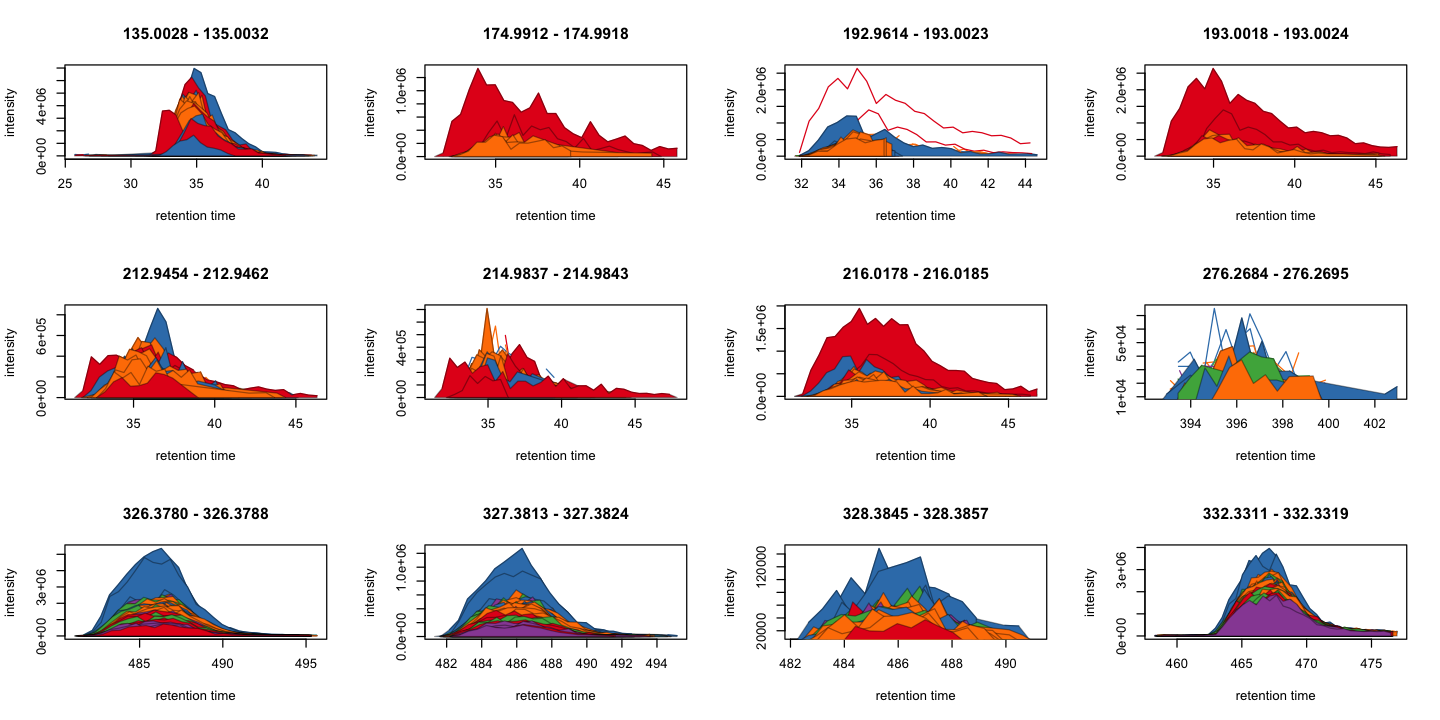

In [67]:
## Extract feature chromatograms
feature_chroms <- featureChromatograms(set, features = rowData(results)$label %in% 
                                       summary$label[1:20])

## Plot feature chromatograms
plot(feature_chroms, col = sample.colours,
     peakBg = sample.colours[chromPeaks(feature_chroms)[, "sample"]])

## Export inclusion list for identification via additional measurements

In [68]:
inclusion.list <- matrix(ncol = 12, nrow = 12, byrow = TRUE, 
                         dimnames = list(NULL, c("Mass [m/z]","Formula [M]",
                                           "Formula type","Species","CS [z]",
                                           "Polarity","Start [min]","End [min]",
                                           "(N)CE","(N)CE type","MSX ID","Comment")))

inclusion.list[,1] <- round(summary$mzmed[1:12],4)
inclusion.list[,6] <- rep("pos", 12)
inclusion.list[,7] <- round((summary$rtmed[1:12] - 30) / 60,2)
inclusion.list[,8] <- round((summary$rtmed[1:12] + 30) / 60,2)
inclusion.list[,12] <- summary$label[1:12]

write.csv(inclusion.list, "inclusion_list_PH_pos.csv", row.names = FALSE, quote = FALSE)

## Export data set for additional evaluations

In [69]:
write_xlsx(list(areas = as.data.frame(assay(results, "raw")), 
                peakdata = as.data.frame(rowData(results)), 
                filedata = as.data.frame(colData(results))), 
           "Enamel_PH_pos.xlsx")

## Save dataset

In [70]:
save.image("Enamel_PH_Pos.RData")

# Appendix

In [71]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] de_DE.UTF-8/de_DE.UTF-8/de_DE.UTF-8/C/de_DE.UTF-8/de_DE.UTF-8

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggpubr_0.6.0                devtools_2.4.5             
 [3] usethis_3.1.0               writexl_1.5.1              
 [5] ggrepel_0.9.6               MASS_7.3-60                
 [7] caret_7.0-1                 lattice_0.22-6             
 [9] Rtsne_0.17                  gplots_3.2.0               
[11] lubridate_1.9.4             forcats_1.0.0              
[13] stringr_1.5.1               dplyr_1.1.4                
[15] purrr_1.0.2                 readr_2.1.5          